In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import gmaps
import os
import warnings

warnings.filterwarnings('ignore')

# Import API key
from ba_config import g_key

# Import datetime in order to label plots with current date
import datetime
d = datetime.datetime.today()
date = f'{d.month}-{d.day}-{d.year}'

In [2]:
crime_df = pd.read_csv("NYC_Crime_October_2014.csv")
crime_df.head()

,ARREST_DATE,PD_DESC,OFNS_DESC,AGE_GROUP,PERP_SEX,PERP_RACE,Latitude,Longitude
0,10/31/14,ASSAULT 3,ASSAULT 3 & RELATED OFFENSES,25-44,M,WHITE HISPANIC,40.731668,-73.989415
1,10/31/14,ASSAULT 3,ASSAULT 3 & RELATED OFFENSES,18-24,M,WHITE HISPANIC,40.864328,-73.868406
2,10/31/14,"MURDER,UNCLASSIFIED",MURDER & NON-NEGL. MANSLAUGHTER,25-44,F,BLACK,40.671111,-73.913563
3,10/31/14,"ASSAULT 2,1,UNCLASSIFIED",FELONY ASSAULT,18-24,F,BLACK,40.648867,-73.950822
4,10/31/14,ASSAULT 3,ASSAULT 3 & RELATED OFFENSES,25-44,M,BLACK,40.717115,-73.920426


In [3]:
# find the closest restaurant of each type to coordinates

base_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"

params = {
    "rankby": "distance",
    "types": "restaurant",
    "keyword": "fast food",
    "key": g_key
}

# Use the lat/lng we recovered to identify airports
for index, row in crime_df.iterrows():
    # get lat, lng from df
    lat = row["Latitude"]
    lng = row["Longitude"]

    # change location each iteration while leaving original params in place
    params["location"] = f"{lat},{lng}"

    # Use the search term: "International Airport" and our lat/lng
    base_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"

    # make request and print url
    name_address = requests.get(base_url, params=params)
    
#     print the name_address url, avoid doing for public github repos in order to avoid exposing key
#     print(name_address.url)

    # convert to json
    name_address = name_address.json()
    # print(json.dumps(name_address, indent=4, sort_keys=True))

    # Since some data may be missing we incorporate a try-except to skip any that are missing a data point.
    try:
        crime_df.loc[index, "Closest Restaurant"] = name_address["results"][0]["name"]
        crime_df.loc[index, "Restaurant Address"] = name_address["results"][0]["vicinity"]
    except (KeyError, IndexError):
        print("Missing field/result... skipping.")

In [4]:
crime_df.head()

,ARREST_DATE,PD_DESC,OFNS_DESC,AGE_GROUP,PERP_SEX,PERP_RACE,Latitude,Longitude,Closest Restaurant,Restaurant Address
0,10/31/14,ASSAULT 3,ASSAULT 3 & RELATED OFFENSES,25-44,M,WHITE HISPANIC,40.731668,-73.989415,Chick-fil-A,"5 University Pl, New York"
1,10/31/14,ASSAULT 3,ASSAULT 3 & RELATED OFFENSES,18-24,M,WHITE HISPANIC,40.864328,-73.868406,McDonald's,"2516 White Plains Rd, The Bronx"
2,10/31/14,"MURDER,UNCLASSIFIED",MURDER & NON-NEGL. MANSLAUGHTER,25-44,F,BLACK,40.671111,-73.913563,KFC,"1667 Pitkin Ave, Brooklyn"
3,10/31/14,"ASSAULT 2,1,UNCLASSIFIED",FELONY ASSAULT,18-24,F,BLACK,40.648867,-73.950822,Burger King,"2848 Church Ave, Brooklyn"
4,10/31/14,ASSAULT 3,ASSAULT 3 & RELATED OFFENSES,25-44,M,BLACK,40.717115,-73.920426,Popeyes Louisiana Kitchen,"259 Vandervoort Ave, Brooklyn"


In [5]:
# Export New Dataframe to CSV
crime_df.to_csv("restaurants.csv", index=False)

In [14]:
restaurants_df = pd.read_csv("restaurants.csv")
restaurants_df.head()

,ARREST_DATE,PD_DESC,OFNS_DESC,AGE_GROUP,PERP_SEX,PERP_RACE,Latitude,Longitude,Closest Restaurant,Restaurant Address
0,10/31/14,ASSAULT 3,ASSAULT 3 & RELATED OFFENSES,25-44,M,WHITE HISPANIC,40.731668,-73.989415,Chick-fil-A,"5 University Pl, New York"
1,10/31/14,ASSAULT 3,ASSAULT 3 & RELATED OFFENSES,18-24,M,WHITE HISPANIC,40.864328,-73.868406,McDonald's,"2516 White Plains Rd, The Bronx"
2,10/31/14,"MURDER,UNCLASSIFIED",MURDER & NON-NEGL. MANSLAUGHTER,25-44,F,BLACK,40.671111,-73.913563,KFC,"1667 Pitkin Ave, Brooklyn"
3,10/31/14,"ASSAULT 2,1,UNCLASSIFIED",FELONY ASSAULT,18-24,F,BLACK,40.648867,-73.950822,Burger King,"2848 Church Ave, Brooklyn"
4,10/31/14,ASSAULT 3,ASSAULT 3 & RELATED OFFENSES,25-44,M,BLACK,40.717115,-73.920426,Popeyes Louisiana Kitchen,"259 Vandervoort Ave, Brooklyn"


In [7]:
by_address = restaurants_df[['Closest Restaurant', 'Restaurant Address','Latitude','Longitude']]

top_ten = pd.DataFrame(by_address['Restaurant Address'].value_counts().head(10))
top_ten = top_ten.reset_index()
top_ten.columns = ['Restaurant Address', 'Number of Crimes']
top_ten = pd.merge(top_ten,restaurants_df,on='Restaurant Address')
top_ten = top_ten[['Closest Restaurant','Restaurant Address','Latitude','Longitude','Number of Crimes']]
top_ten.rename(columns ={'Closest Restaurant':'Restaurant',
                         'Restaurant Address':'Address'})
top_ten = top_ten.drop_duplicates(subset = 'Restaurant Address').reset_index()
del top_ten['index']
top_ten

,Closest Restaurant,Restaurant Address,Latitude,Longitude,Number of Crimes
0,White Castle,"3101 Atlantic Ave, Brooklyn",40.671412,-73.881512,67
1,Kennedy Chicken And Pizza,"2041 Grand Concourse, The Bronx",40.853587,-73.900591,63
2,Texas Chicken & Burgers,"2660 3rd Ave, The Bronx",40.812200,-73.930229,62
3,White Castle,"1677 Bruckner Blvd, The Bronx",40.823387,-73.870170,55
4,Kennedy fried chicken,"381 Bedford Park Blvd, The Bronx",40.869407,-73.879998,53
5,Hyderi Fast Food Inc,"4049 Laconia Ave, The Bronx",40.885846,-73.845839,53
6,KFC,"1667 Pitkin Ave, Brooklyn",40.671111,-73.913563,51
7,McDonald's,"875 Garrison Ave, The Bronx",40.804013,-73.878332,48
8,Coffee cosina,"1350 Jerome Ave, The Bronx",40.837782,-73.919458,48
9,McDonald's,"2870 3rd Ave, The Bronx",40.822298,-73.911694,42


In [8]:
# Using the template add the hotel marks to the heatmap
info_box_template = """
<dl>
<dt>Restaurant</dt><dd>{Closest Restaurant}</dd>
<dt>Address</dt><dd>{Restaurant Address}</dd>
<dt>Number of Crimes Nearby</dt><dd>{Number of Crimes}</dd>
</dl>
"""
# Store the DataFrame Row
# NOTE: be sure to update with your DataFrame name
restaurant_info = [info_box_template.format(**row) for index, row in top_ten.iterrows()]
locations = top_ten[["Latitude", "Longitude"]]

In [12]:
# Add marker layer
gmaps.configure(api_key=g_key)

fig = gmaps.figure()

marker_layer = gmaps.marker_layer(locations, info_box_content=restaurant_info)
fig.add_layer(marker_layer)

# Assign the marker layer to a variable
markers = gmaps.marker_layer(locations)

# Add the layer to the map
fig.add_layer(markers)

# Display Map
fig

Figure(layout=FigureLayout(height='420px'))

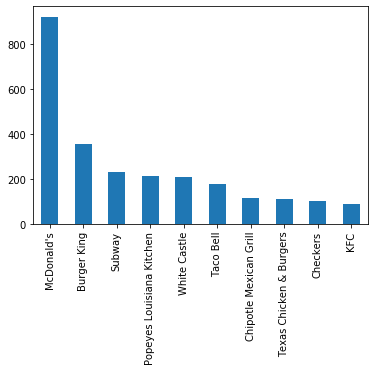

In [15]:
# Bar graph of top ten most dangerous restaurants in NYC by franchise
restaurants_df['Closest Restaurant'].value_counts().head(10).plot.bar()

In [11]:
# Find number of fast food restaurants all in all in NYC to compare